# Running the Whole Longitudinal ARIA-E Analysis Pipeline

In [1]:
import numpy as np
import os
import pandas as pd
import shutil
import nipype.interfaces.fsl as fsl
import matplotlib.pyplot as plt
from pathlib import Path
import nibabel as nib
from intensity_normalization.typing import Modality
from intensity_normalization.normalize.nyul import NyulNormalize
from intensity_normalization.plot.histogram import HistogramPlotter

# import my own helper modules
import Registration as rg 
import Process3DFLAIR as p3df
import ZscoreClustering as zc

### Run the preprocessing pipeline and generate the maps for the subject

In [7]:
# open the subject info table and turn into pd dataframe
subject_info_df = pd.read_csv('~/Documents/MRes_Project/subject_info.csv')
print(subject_info_df) # print current subject info

# select the subject/s to be processed (set this just to loop through all if that's what we want)
sp = [1]

for i in range(0, len(sp)):
    # select patient ID and number of time points in the sequences
    test_subject_id = subject_info_df.Subject_ID[sp[i]]
    test_total_num_time_points = subject_info_df.Time_Points[sp[i]]

    # select the time points we want to consider in analysis
    test_time_points_to_consider = list(range(1, test_total_num_time_points + 1))

    # define the type of registration we'd like to use
    registration_method = 'affinefsl'

    # we don't want to normalise across all patients
    inter_subject = False

    #  initialise a preprocess pipeline based on the test subject
    testProcess3DFLAIR = p3df.Process3DFLAIR(subject_info_df, test_subject_id, test_total_num_time_points, test_time_points_to_consider, registration_method, inter_subject) 

    # compute the Z-score map for the variance
    z_score_in_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/variance_maps/{test_subject_id}_var.nii.gz" # variance
    z_score_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/z_score_map.nii.gz" # variance 
    log_map = True # we need to take the log of the variance maps to make it more 'normal'
    testProcess3DFLAIR.calcZScoreMap(z_score_in_file, z_score_out_file, log_map)


   Subject_ID  Time_Points
0  B-RAP_0027            7
1  B-RAP_0100            5
2  B-RAP_0028            3
Analysing subject: B-RAP_0100
Computed Z-Score map


### Run the clustering on the Z-score map

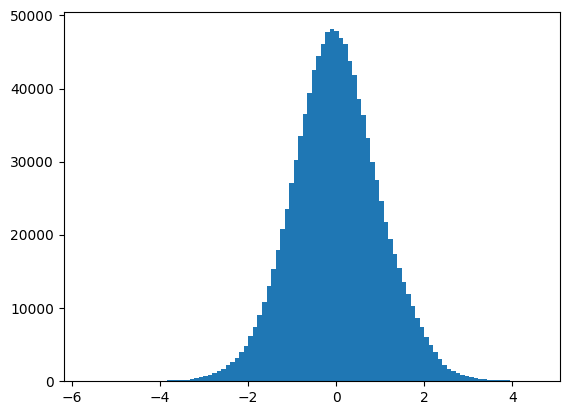

95th Percentile of Z-score Map: 
1.6831333251872098
Z-score map clustered.
Clusters filtered.
Adjusted intensity thresholded cluster map saved.
Clusters thresholded at 10 voxels


In [15]:
# load in the z-score map for the most obvious subject

z_score_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/z_score_map.nii.gz" # variance 
z_score_map = nib.load(z_score_map_file).get_fdata()
z_score_map_flat = z_score_map.flatten()

# ignoring, the background, plot the histogram of the z-score map and find the 95th percentile
brain_mask_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/brain_nifti/masks/{test_subject_id}_0{test_total_num_time_points}_D1.nii"
brain_mask = nib.load(brain_mask_file)
brain_mask_flat = brain_mask.get_fdata().flatten()

# plot the histogram of the z-score map, ignoring the brain_mask
z_score_map_brain_only = z_score_map_flat[brain_mask_flat > 0]
plt.hist(z_score_map_brain_only, bins=100)
plt.show()

# find the 95th percentile of the z-score map
z_score_map_95th_percentile = np.percentile(z_score_map_brain_only, 95)

print('95th Percentile of Z-score Map: ')
print(z_score_map_95th_percentile)

# run the clustering pipeline
testZscoreClustering = zc.ZscoreClustering()
cluster_info_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/cluster_info.txt"
cluster_out_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/raw_clusters.nii.gz"
threshold = z_score_map_95th_percentile
testZscoreClustering.clusterZscore(z_score_map_file, cluster_info_out_file, cluster_out_file, threshold)

# filter clusters so only those above 10 voxels are retained
thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/thresholded_clusters.nii.gz"
adjusted_intensity_thresholded_cluster_map_file = f"/home/ela/Documents/B-RAPIDD/{test_subject_id}/3D-FLAIR/z_score_maps/variance/clusters/adjusted_intesity_thresholded_clusters.nii.gz"
testZscoreClustering.filterClusters(cluster_out_file, cluster_info_out_file, thresholded_cluster_map_file, adjusted_intensity_thresholded_cluster_map_file)

print("Clusters thresholded at 10 voxels")